In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gensim
import sklearn
from sklearn.datasets import fetch_20newsgroups
import re

## Prepare the data

In [2]:
cats = None

newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=cats)

newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=cats)

In [3]:
def clean(text):
    """Remove posting header, split by sentences and words, keep only letters"""
    result = []
    lines = re.split('[?!.:]\s', re.sub('^.*Lines: \d+', '', re.sub('\n', ' ', text)))
    for line in lines:
        result = result + re.sub('[^a-zA-Z]', ' ', line).lower().split()
    return result

sentences = [clean(text) for text in newsgroups_train.data]

sentences_test = [clean(text) for text in newsgroups_test.data]

In [4]:
len(sentences)

11314

In [5]:
len(sentences_test)

7532

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
from collections import Counter

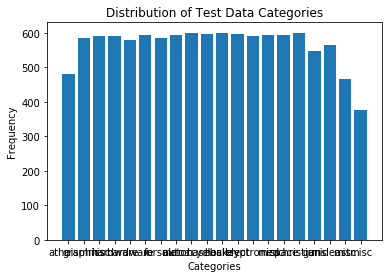

In [11]:
train_des = Counter(newsgroups_train.target)

plt.bar(list(train_des.keys()), list(train_des.values()), tick_label = [i.split('.')[-1] for i in newsgroups_train.target_names])
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title('Distribution of Test Data Categories')

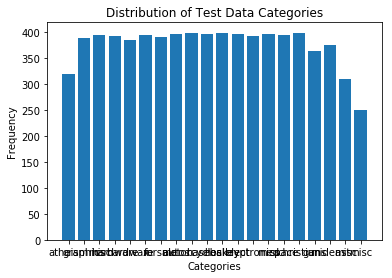

In [15]:
test_des = Counter(newsgroups_test.target)

plt.bar(list(test_des.keys()), list(test_des.values()), tick_label = [i.split('.')[-1] for i in newsgroups_test.target_names])
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title('Distribution of Test Data Categories')

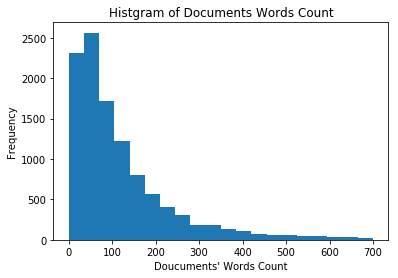

In [16]:
plt.hist([len(i) for i in sentences], range = (0,700), bins = 20)
plt.title('Histgram of Documents Words Count')
plt.xlabel("Doucuments' Words Count")
plt.ylabel('Frequency')

In [17]:
words = []
for sentence in sentences:
    words = words + sentence
count = Counter(words)

In [18]:
keys= [i[0] for i in count.most_common()]
values = [i[1] for i in count.most_common()]

In [19]:
len(count)

72904

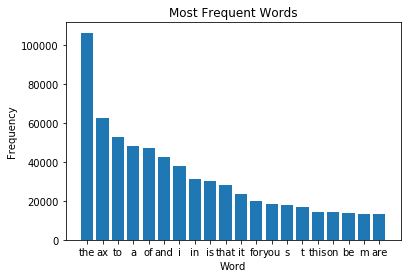

In [20]:
plt.bar(range(20), values[:20], tick_label =keys[:20])
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Frequent Words')

## Method 1: Bag of Words
### Preprocess the data with tf-idf

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

vector_train = vectorizer.fit_transform(newsgroups_train.data)

vector_test = vectorizer.transform(newsgroups_test.data)

### Classify with LogisticRegression

In [22]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

clf.fit(vector_train, newsgroups_train.target).score(vector_test, newsgroups_test.target)

0.67750929368029744

### Classify with RandomForest

In [23]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

clf.fit(vector_train, newsgroups_train.target).score(vector_test, newsgroups_test.target)

0.42790759426447161

### Classify with SVM

In [24]:
from sklearn.svm import SVC

clf = SVC(kernel = 'linear')

clf.fit(vector_train, newsgroups_train.target).score(vector_test, newsgroups_test.target)

0.6631704726500266

In [25]:
from sklearn.svm import SVC

clf = SVC()

clf.fit(vector_train, newsgroups_train.target).score(vector_test, newsgroups_test.target)

0.052973977695167283

## Method 2: Word2Vec

In [57]:
dim = 100

model_news = gensim.models.Word2Vec(sentences, workers=4, size=dim, min_count=5, window=10, sample=1e-3)

#### visualize the word-vector

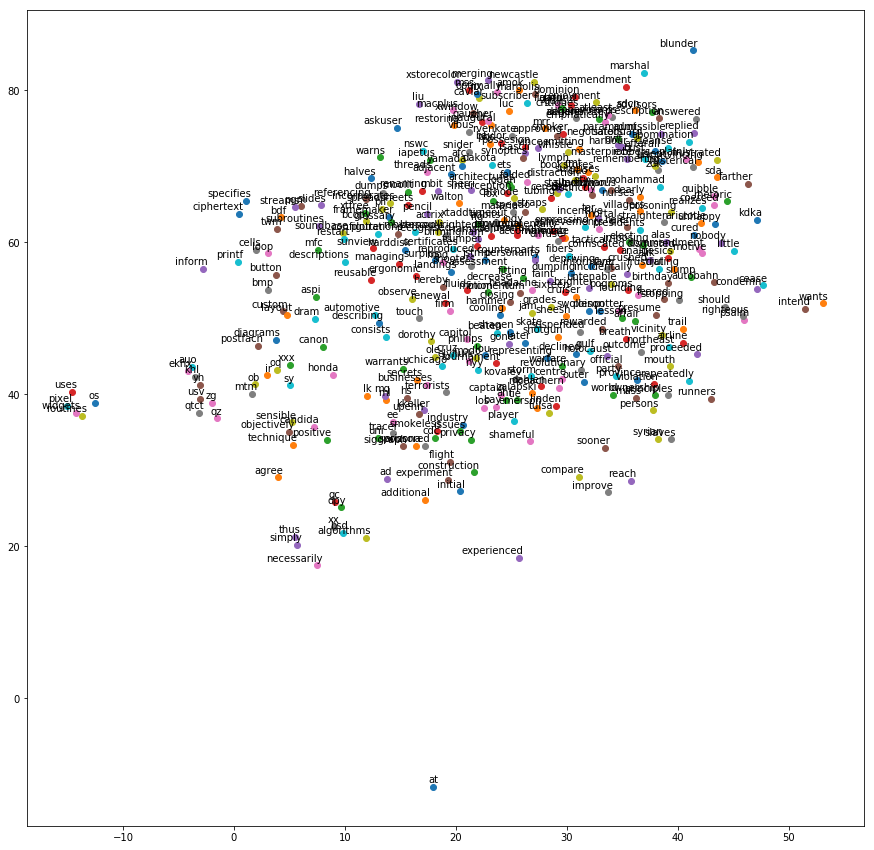

In [58]:
from matplotlib import pylab

from sklearn.manifold import TSNE

label = list(model_news.wv.vocab.keys())[:400]

X = model_news[label]

tsne = TSNE(n_components=2, init='pca', n_iter=5000)
X_tsne = tsne.fit_transform(X)

def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

plot(X_tsne, label)

### convert document to vector

####  average the words' vector in each document

In [28]:
word2vec_train = np.zeros((len(sentences), dim))
for i, sentence in enumerate(sentences):
    count = 0.0
    for word in sentence:
        if word in model_news.wv.vocab:
            count += 1
            word2vec_train[i] += model_news[word]
    if count != 0:
        word2vec_train[i] = word2vec_train[i]/count
    
sentences_test = [clean(text) for text in newsgroups_test.data]
word2vec_test = np.zeros((len(sentences_test), dim))
for i, sentence in enumerate(sentences_test):
    count = 0
    for word in sentence:
        if word in model_news.wv.vocab:
            count += 1
            word2vec_test[i] += model_news[word]
    if count != 0:
        word2vec_test[i] = word2vec_test[i]/count

In [29]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

clf.fit(word2vec_train, newsgroups_train.target).score(word2vec_train, newsgroups_train.target)

0.48285310235106949

In [30]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

clf.fit(word2vec_train, newsgroups_train.target).score(word2vec_test, newsgroups_test.target)

0.28876792352628783

In [31]:
from sklearn.svm import SVC

clf = SVC(kernel = 'linear')

clf.fit(word2vec_train, newsgroups_train.target).score(word2vec_test, newsgroups_test.target)

0.42272968667020711

### Use text8 to train skip-gram model

In [32]:
url = 'http://mattmahoney.net/dc/'
import os
from six.moves.urllib.request import urlretrieve

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception(
          'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [33]:
dim = 100

from gensim.models import word2vec

text =  word2vec.Text8Corpus('text8')

model_text = word2vec.Word2Vec(text, size = dim)

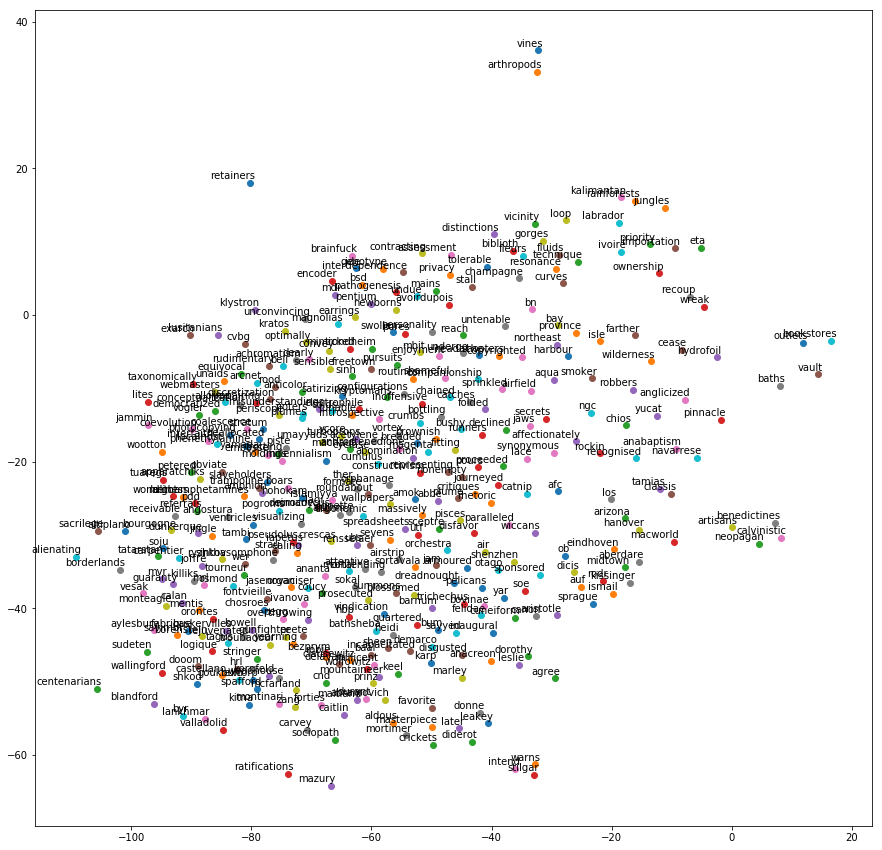

In [34]:
label = list(model_text.wv.vocab.keys())[:400]

X = model_text[label]

tsne = TSNE(n_components=2, init='pca', n_iter=5000)
X_tsne = tsne.fit_transform(X)

def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

plot(X_tsne, label)

#### average the words' vector in each document

In [35]:
word2vec_train = np.zeros((len(sentences), dim))
for i, sentence in enumerate(sentences):
    count = 0.0
    for word in sentence:
        if word in model_text.wv.vocab:
            count += 1
            word2vec_train[i] += model_text[word]
    if count != 0:
        word2vec_train[i] = word2vec_train[i]/count
    
word2vec_test = np.zeros((len(sentences_test), dim))
for i, sentence in enumerate(sentences_test):
    count = 0
    for word in sentence:
        if word in model_text.wv.vocab:
            count += 1
            word2vec_test[i] += model_text[word]
    if count != 0:
        word2vec_test[i] = word2vec_test[i]/count

In [36]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

clf.fit(word2vec_train, newsgroups_train.target).score(word2vec_test, newsgroups_test.target)

0.47304832713754646

In [37]:
from sklearn.svm import SVC

clf = SVC(kernel = 'linear')

clf.fit(word2vec_train, newsgroups_train.target).score(word2vec_test, newsgroups_test.target)

0.46229421136484333

In [38]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

clf.fit(word2vec_train, newsgroups_train.target).score(word2vec_test, newsgroups_test.target)

0.27018056293149229

## Method: 3 Deep Learning

In [40]:
import tflearn
from tflearn.data_utils import to_categorical, pad_sequences

### LSTM with Word2Vec_news

In [60]:
word2idx = dict([(k, v.index) for k, v in model_news.wv.vocab.items()])
word2idx['UNK'] = len(word2idx)

idx2word = dict([(v.index, k) for k, v in model_news.wv.vocab.items()])
idx2word[len(idx2word)] = 'UNK'

embedding_weight = np.zeros([len(idx2word), model_news.wv.syn0.shape[1]])
embedding_weight[:-1] = model_news.wv.syn0

In [61]:
trainX_raw = []
testX_raw = []

for sentence in sentences: 
    tmp = []
    for word in sentence:
        if word in word2idx:
            tmp.append(word2idx[word])
        else:
            tmp.append(word2idx['UNK'])
    trainX_raw.append(tmp)
    
for sentence in sentences_test:
    tmp = []
    for word in sentence:
        if word in word2idx:
            tmp.append(word2idx[word])
        else:
            tmp.append(word2idx['UNK'])
    testX_raw.append(tmp)

In [62]:
max_length = 200
trainX = pad_sequences(trainX_raw, maxlen=max_length, value=0.)
testX = pad_sequences(testX_raw, maxlen=max_length, value=0.)
# Converting labels to binary vectors
trainY = to_categorical(newsgroups_train.target, nb_classes=20)
testY = to_categorical(newsgroups_test.target, nb_classes=20)

In [63]:
tf.reset_default_graph()
net = tflearn.input_data([None, max_length])
net = tflearn.embedding(net, input_dim=embedding_weight.shape[0], output_dim=embedding_weight.shape[1],
                        weights_init=tf.constant(embedding_weight, dtype=tf.float32), trainable=False)
net = tflearn.lstm(net, 128, dropout=0.5, return_seq = True)
net = tflearn.lstm(net, 128, dropout=0.5)
net = tflearn.fully_connected(net, 20, activation='softmax')
net = tflearn.regression(net, optimizer='adam', learning_rate=0.001,
                         loss='categorical_crossentropy')

# Training
model = tflearn.DNN(net, tensorboard_verbose=0)
model.fit(trainX, trainY, validation_set=(testX, testY), show_metric=True, n_epoch = 200,
          batch_size=256)

Training Step: 8999  | total loss: 0.86059 | time: 12.529s
| Adam | epoch: 200 | loss: 0.86059 - acc: 0.7162 -- iter: 11264/11314
Training Step: 9000  | total loss: 0.85757 | time: 15.569s
| Adam | epoch: 200 | loss: 0.85757 - acc: 0.7172 | val_loss: 1.69009 - val_acc: 0.5224 -- iter: 11314/11314
--


### LSTM with Word2Vec_text8

In [47]:
word2idx = dict([(k, v.index) for k, v in model_text.wv.vocab.items()])
word2idx['UNK'] = len(word2idx)

idx2word = dict([(v.index, k) for k, v in model_text.wv.vocab.items()])
idx2word[len(idx2word)] = 'UNK'

embedding_weight = np.zeros([len(idx2word), model_text.wv.syn0.shape[1]])
embedding_weight[:-1] = model_text.wv.syn0

In [48]:
trainX_raw = []
testX_raw = []

for sentence in sentences: 
    tmp = []
    for word in sentence:
        if word in word2idx:
            tmp.append(word2idx[word])
        else:
            tmp.append(word2idx['UNK'])
    trainX_raw.append(tmp)
    
for sentence in sentences_test:
    tmp = []
    for word in sentence:
        if word in word2idx:
            tmp.append(word2idx[word])
        else:
            tmp.append(word2idx['UNK'])
    testX_raw.append(tmp)

In [49]:
max_length = 200
trainX = pad_sequences(trainX_raw, maxlen=max_length, value=0.)
testX = pad_sequences(testX_raw, maxlen=max_length, value=0.)
# Converting labels to binary vectors
trainY = to_categorical(newsgroups_train.target, nb_classes=20)
testY = to_categorical(newsgroups_test.target, nb_classes=20)

In [52]:
tf.reset_default_graph()
net = tflearn.input_data([None, max_length])
net = tflearn.embedding(net, input_dim=embedding_weight.shape[0], output_dim=embedding_weight.shape[1],
                        weights_init=tf.constant(embedding_weight, dtype=tf.float32), trainable=False)
net = tflearn.lstm(net, 128, dropout=0.5, return_seq = True)
net = tflearn.lstm(net, 128, dropout=0.5, return_seq = True)
net = tflearn.lstm(net, 128, dropout=0.5)
net = tflearn.fully_connected(net, 20, activation='softmax')
net = tflearn.regression(net, optimizer='adam', learning_rate=0.001,
                         loss='categorical_crossentropy')

# Training
model = tflearn.DNN(net, tensorboard_verbose=0)
model.fit(trainX, trainY, validation_set=(testX, testY), show_metric=True, n_epoch = 300,
          batch_size=256)

Training Step: 13481  | total loss: 0.98612 | time: 20.391s
| Adam | epoch: 300 | loss: 0.98612 - acc: 0.6852 -- iter: 11264/11314
Training Step: 13482  | total loss: 0.97614 | time: 24.911s
| Adam | epoch: 300 | loss: 0.97614 - acc: 0.6901 | val_loss: 1.59564 - val_acc: 0.5530 -- iter: 11314/11314
--
